In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay as cmd, RocCurveDisplay as rcd
from sklearn.naive_bayes import MultinomialNB

sns.set_theme()

In [3]:
lines = [
'Four score and 7 years ago our fathers brought forth,',
'... a new NATION, conceived in liberty $$$,',
'and dedicated to the PrOpOsItIoN that all men are created equal',
'One nation\'s freedom equals #freedom for another $nation!'
]

# vectorize lines
vectorizer = CountVectorizer(stop_words="english")
word_matrix = vectorizer.fit_transform(lines)

feature_names = vectorizer.get_feature_names_out()
line_names = [f'Line {(i+1):d}' for i,_ in enumerate(word_matrix)]

df = pd.DataFrame(data=word_matrix.toarray(), columns=feature_names, index=line_names)
df.head()

,ago,brought,conceived,created,dedicated,equal,equals,fathers,forth,freedom,liberty,men,nation,new,proposition,score,years
Line 1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
Line 2,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0
Line 3,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0
Line 4,0,0,0,0,0,0,1,0,0,2,0,0,2,0,0,0,0


In [11]:
# function to remove all numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text).lower()

vectorizer = CountVectorizer(stop_words="english", preprocessor=preprocess_text)
word_matrix = vectorizer.fit_transform(lines)
word_matrix.toarray()

array([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0]])

## Sentiment Analysis

In [12]:
!wget -P sample_data/ https://raw.githubusercontent.com/jeffprosise/Applied-Machine-Learning/main/Chapter%204/Data/reviews.csv

--2024-05-23 18:15:32--  https://raw.githubusercontent.com/jeffprosise/Applied-Machine-Learning/main/Chapter%204/Data/reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64751378 (62M) [text/plain]
Saving to: ‘sample_data/reviews.csv’

reviews.csv         100%[===================>]  61.75M  5.28MB/s    in 13s     

2024-05-23 18:15:49 (4.82 MB/s) - ‘sample_data/reviews.csv’ saved [64751378/64751378]



In [4]:
df = pd.read_csv("sample_data/reviews.csv", encoding="ISO-8859-1")
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [5]:
# check for non-null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [6]:
# check instances for each class
df.groupby("Sentiment").describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  When i got this movie free from my job, along ...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

In [7]:
# delete duplicates
df = df.drop_duplicates()
df.groupby("Sentiment").describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Once again Mr. Costner has dragged out a movie...   
1          24884  24884  I went and saw this movie last night after bei...   

                
          freq  
Sentiment       
0            1  
1            1

In [8]:
# vectorize
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=20, stop_words="english")
x = vectorizer.fit_transform(df["Text"])
y = df["Sentiment"]

In [9]:
# split dataset
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size=0.5, random_state=0)

In [10]:
# train LogisticRegression model
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

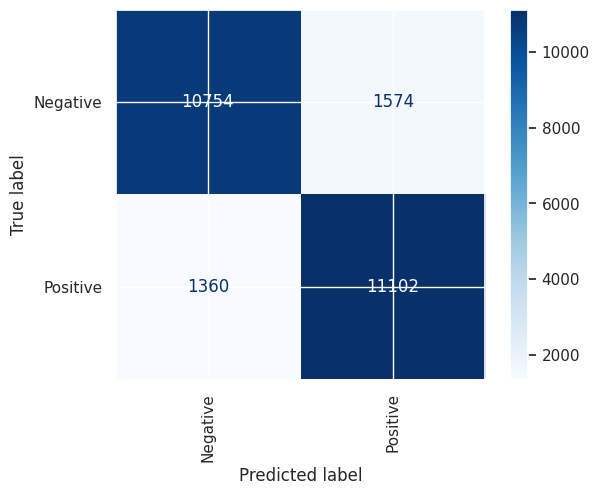

In [11]:
# confusion matrix
%matplotlib inline
cmd.from_estimator(model, x_test, y_test, display_labels=['Negative', 'Positive'], cmap="Blues", xticks_rotation="vertical")

In [14]:
text = 'The long lines and poor customer service really turned me off'
model.predict_proba(vectorizer.transform([text]))[0][1]

0.2564858171607219

In [15]:
text = 'The food was great and the service was excellent!'
model.predict_proba(vectorizer.transform([text]))[0][1]

0.9195510458481618

## Spam Filtering

In [16]:
!wget -P sample_data/ https://raw.githubusercontent.com/jeffprosise/Applied-Machine-Learning/main/Chapter%204/Data/ham-spam.csv

--2024-05-23 21:16:27--  https://raw.githubusercontent.com/jeffprosise/Applied-Machine-Learning/main/Chapter%204/Data/ham-spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1030970 (1007K) [text/plain]
Saving to: ‘sample_data/ham-spam.csv’

ham-spam.csv        100%[===================>]   1007K  1.35MB/s    in 0.7s    

2024-05-23 21:16:29 (1.35 MB/s) - ‘sample_data/ham-spam.csv’ saved [1030970/1030970]



In [2]:
df = pd.read_csv('sample_data/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


In [5]:
df.groupby("IsSpam").describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        500    499   paso firm capacity award memorandumlouise del...    2
1        500    500  take the reinsbecomeyour employer substantial ...    1

In [7]:
df= df.drop_duplicates()
df.groupby("IsSpam").describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  key issues going forwarda year end reviews rep...    1
1        500    500  take the reinsbecomeyour employer substantial ...    1

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words="english")
x = vectorizer.fit_transform(df["Text"])
y = df["IsSpam"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [11]:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

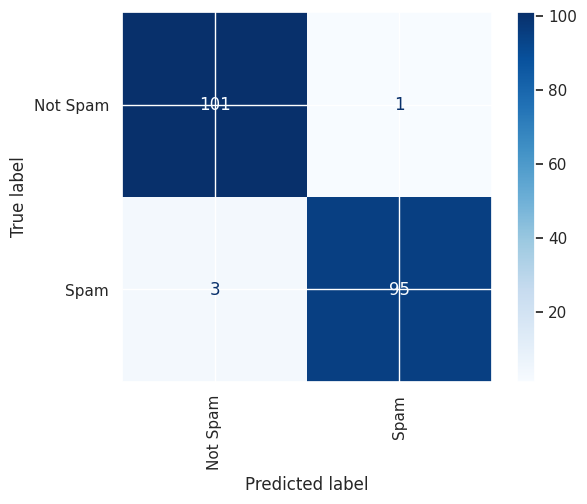

In [12]:
%matplotlib inline
cmd.from_estimator(model, x_test, y_test, display_labels=["Not Spam", "Spam"], cmap="Blues", xticks_rotation="vertical")

In [13]:
model.score(x_test, y_test)

0.98

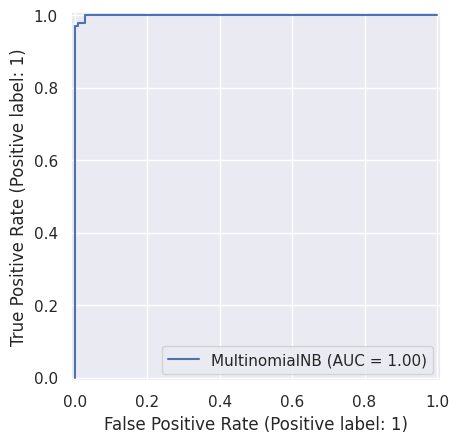

In [15]:
rcd.from_estimator(model, x_test, y_test)

### Making Predictions

In [16]:
msg = 'Can you attend a code review on Tuesday to make sure the logic is solid?'
input = vectorizer.transform([msg])
model.predict(input)[0]

0

In [19]:
# probability that its not a spam
model.predict_proba(input)[0][0]

0.9999497111473539

In [22]:
msg = 'Why pay more for expensive meds when you can order them online and save $$$?'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

In [25]:
input.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [23]:
model.predict_proba(input)[0][1]

0.9997857610873945